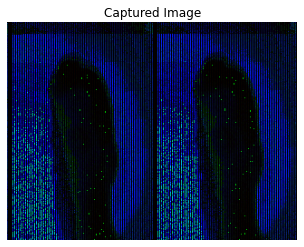

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, MMIO
from PIL import Image

# Load the FPGA bitstream
overlay = Overlay("./design_1.bit")

# BRAM MMIO
bram_base_address = 0xA0000000  # Adjust this to your BRAM controller's base address
bram_size = 320 * 240 * 2  # Example for 320x240 image, each pixel 2 bytes for RGB565

# Initialize MMIO instance for BRAM
bram = MMIO(bram_base_address, bram_size)

# Define the number of pixels and bytes per pixel
num_pixels = 320 * 240
bytes_per_pixel = 2

# Initialize a numpy array to store the image data
image_data = np.zeros((num_pixels,), dtype=np.uint16)

# Read the data in 4-byte aligned chunks
for i in range(0, num_pixels, 2):
    # Read 4 bytes (32 bits) at a time
    data_32bit = bram.read(i * bytes_per_pixel, 4)

    # Extract two 16-bit RGB565 values
    pixel1 = data_32bit & 0xFFFF
    pixel2 = (data_32bit >> 16) & 0xFFFF

    # Store the pixels in the array
    image_data[i] = pixel1
    if i + 1 < num_pixels:
        image_data[i + 1] = pixel2

# Reshape the array to (240, 320) for the image format
image_data = image_data.reshape((240, 320))

# Convert from RGB565 to RGB888
def rgb565_to_rgb888(rgb565):
    # Extract RGB components from RGB565 format
    red = (rgb565 >> 11) & 0x1F
    green = (rgb565 >> 5) & 0x3F
    blue = rgb565 & 0x1F
    
    # Scale components to 8-bit values
    red = (red * 255 // 31).astype(np.uint8)
    green = (green * 255 // 63).astype(np.uint8)
    blue = (blue * 255 // 31).astype(np.uint8)
    
    return np.stack((red, green, blue), axis=-1)

# Apply RGB565 to RGB888 conversion
image_rgb888 = rgb565_to_rgb888(image_data)

# Display the image
plt.figure(figsize=(6, 4))
plt.imshow(image_rgb888)
plt.title("Captured Image")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Optionally, save the image using PIL
image_pil = Image.fromarray(image_rgb888)
image_pil.save("captured_image.png")
